# Imports

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
import random

# Loading in Data

In [2]:
def grab_files(root):
    dataset = []
    for path, dirs, files in os.walk(root):
        for file in files:
            if '.DS_Store' not in file:
                dataset.append(os.path.join(path, file))
    return dataset

In [27]:
cars = grab_files("./vehicles")
notcars = grab_files("./non-vehicles")

In [87]:
color_space = 'YCrCb' 
orient = 8
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 'ALL'
spatial_size = (16, 16) 
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True 
y_start_stop = [400,700]
scale = 1.5
xy_window = (64,64)
xy_overlap = (0.85,0.85)

In [38]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def convert_image(image, cspace):

    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    return feature_image

In [67]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def single_img_features(img, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    feature_image = convert_image(img,color_space)    
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

def extract_features(imgs, color_space='YCrCb', spatial_size=(16,16),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        feature_image = convert_image(image,color_space)    

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

In [47]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

Text(0.5, 1.0, 'Non-car Spatial features')

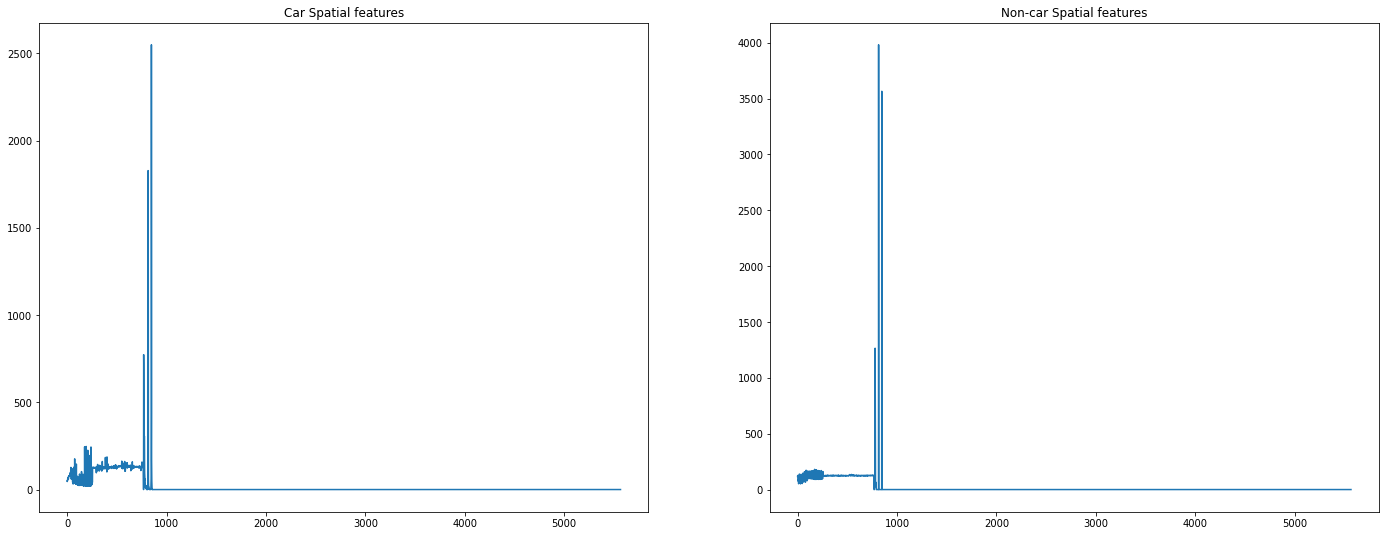

In [68]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

i = cv2.cvtColor(cv2.imread(random.choice(cars)),cv2.COLOR_BGR2RGB)
j = cv2.cvtColor(cv2.imread(random.choice(notcars)),cv2.COLOR_BGR2RGB)

car_feat = single_img_features(img=i, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_feat = single_img_features(img=j, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
ax1.plot(car_feat)
ax1.set_title("Car Spatial features")
ax2.plot(notcar_feat)
ax2.set_title("Non-car Spatial features")

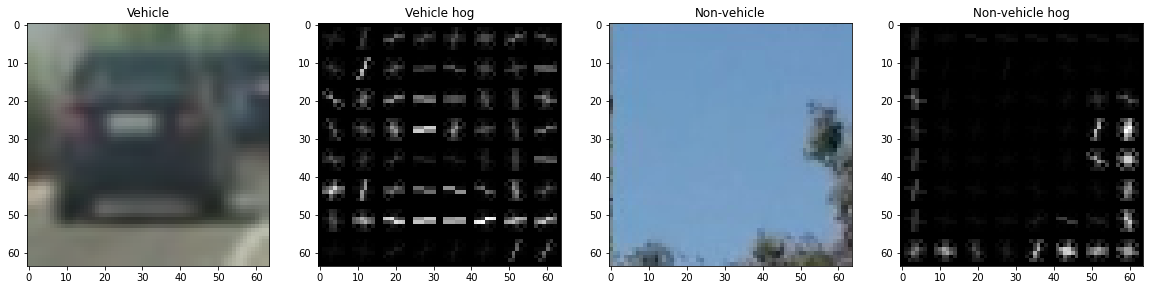

In [51]:
car1 = cv2.cvtColor(cv2.imread(cars[0]),cv2.COLOR_BGR2RGB)
not_car1 = cv2.cvtColor(cv2.imread(notcars[0]),cv2.COLOR_BGR2RGB)

_, hog1 = get_hog_features(car1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog2 = get_hog_features(not_car1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Vehicle')
ax1.imshow(car1, cmap='gray')
ax2.set_title('Vehicle hog')
ax2.imshow(hog1, cmap='gray')
ax3.set_title('Non-vehicle')
ax3.imshow(not_car1, cmap='gray')
ax4.set_title('Non-vehicle hog')
ax4.imshow(hog2, cmap='gray')

# SVM Model

In [52]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

t=time.time()

svc.fit(X_train, y_train)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
11.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


In [101]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[400,700], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85)):
    
    
    x_start_stop = [0,img.shape[1]]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0] 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list 

def find_cars(img, clf, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

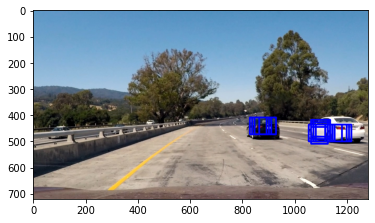

In [102]:
img = cv2.cvtColor(cv2.imread('test_img/test1.jpg'),cv2.COLOR_BGR2RGB)
car_loc = find_cars(img, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
out_img = draw_boxes(image, car_loc)
plt.imshow(out_img)

# Heat Pipeline + False Positives

In [77]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def heat_pipeline(img,car_loc):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,car_loc)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    return heatmap, labels

In [78]:
def vis_img(img):
    
    car_loc = find_cars(img, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    
    heatmap, labels = heat_pipeline(img,car_loc)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(draw_img)
    ax2.imshow(heatmap, cmap='hot')
    plt.show()

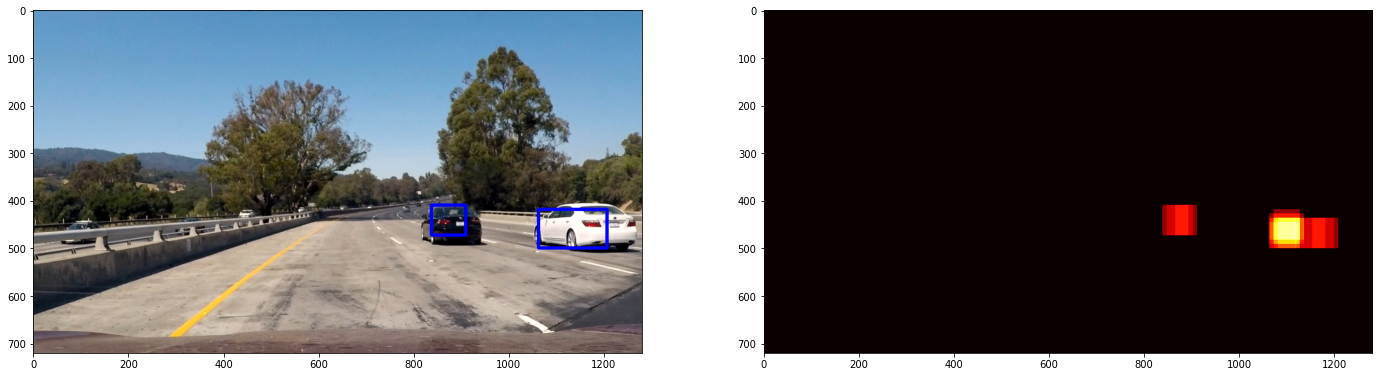

In [108]:
img = cv2.cvtColor(cv2.imread('test_img/test1.jpg'),cv2.COLOR_BGR2RGB)
vis_img(img)

# HOG Subsampling Window Search

In [85]:
def hog_sub_find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        ctrans_tosearch = convert_image(img_tosearch,color_space)
    else: 
        ctrans_tosearch = np.copy(img_tosearch)  
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step 
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step 

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

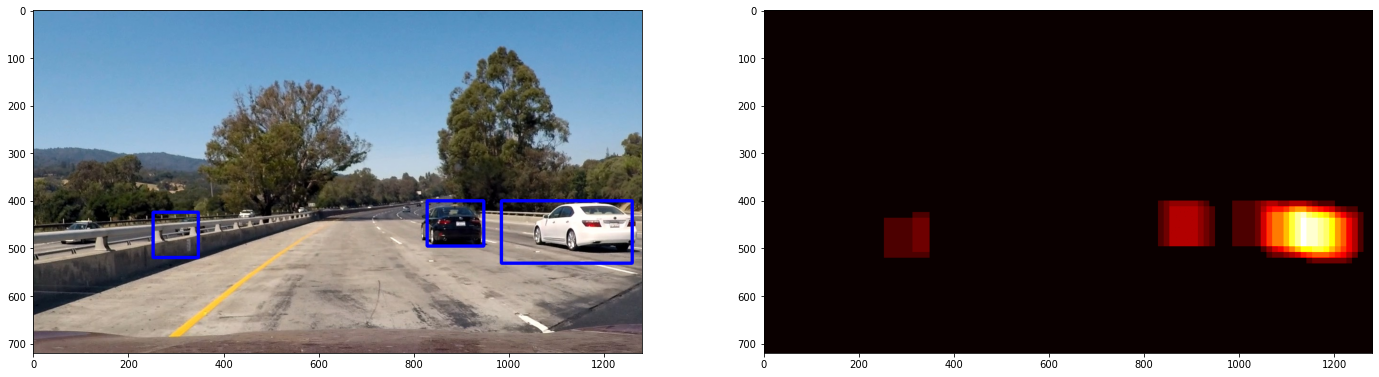

In [94]:
read_img = mpimg.imread('test_img/test1.jpg')
car_loc = hog_sub_find_cars(img=read_img, color_space=color_space, ystart=400, ystop=550, scale=scale, svc=svc, X_scaler=X_scaler, 
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, window=64)    

heatmap, labels = heat_pipeline(read_img,car_loc)
draw_img = draw_labeled_bboxes(np.copy(read_img), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(draw_img)
ax2.imshow(heatmap, cmap='hot')
plt.show()

# Writing out video 

In [110]:
def process_img(image):
    car_loc = find_cars(image, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)    
    heatmap, labels = heat_pipeline(image,car_loc)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [ ]:
def process_img(img):
    
    car_loc = hog_sub_find_cars(img=img, color_space=color_space, ystart=y_start_stop[0], ystop=y_start_stop[1], scale=scale, svc=svc, X_scaler=X_scaler, 
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins, window=xy_window[0])    
    heatmap, labels = heat_pipeline(img,car_loc)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)      
    return draw_img

In [113]:
output_vid = 'final_tracker4.mp4'
input_vid = 'project_video.mp4'
# input_vid = 'lane_tracker.mp4'

clip1 = VideoFileClip(input_vid)
video_clip = clip1.fl_image(process_img)
video_clip.write_videofile(output_vid, audio=False, fps=30, threads=12)

                                                                                                                       
t:   0%|▎                                                                 | 6/1512 [13:16<9:19:48, 22.30s/it, now=None]
                                                                                                                       
t:   0%|▎                                                                 | 6/1512 [10:20<9:45:25, 23.32s/it, now=None]

t:   0%|                                                                            | 0/1512 [00:00<?, ?it/s, now=None]

Moviepy - Building video final_tracker4.mp4.
Moviepy - Writing video final_tracker4.mp4





t:   0%|                                                                  | 2/1512 [00:24<5:03:37, 12.06s/it, now=None]

t:   0%|▏                                                                 | 3/1512 [00:48<7:16:33, 17.36s/it, now=None]

t:   0%|▏                                                                 | 4/1512 [01:14<8:37:09, 20.58s/it, now=None]

KeyboardInterrupt: 

In [105]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_vid))